In [8]:
%matplotlib inline

In [77]:
# path = "data/dogscats/sample/"
path = "data/dogscats/" # take more time

In [10]:
import os
import json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [11]:
import utils
from utils import plots

In [12]:
batch_size = 64

In [13]:
import vgg16
from vgg16 import Vgg16

In [14]:
vgg = Vgg16()
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=1)

Found 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Epoch 1/1
16/16 [==============================] - 18s - loss: 1.5045 - acc: 0.4375 - val_loss: 0.4387 - val_acc: 0.6250


## review the model

In [ ]:
vgg = Vgg16()

In [18]:
batches = vgg.get_batches(path+'train', batch_size=4)

Found 16 images belonging to 2 classes.


In [19]:
imgs,labels=next(batches)

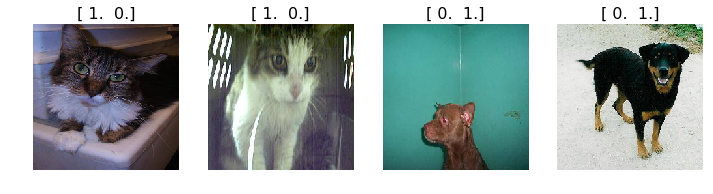

In [20]:
plots(imgs,titles=labels)

In [21]:
vgg.predict(imgs,True)

(array([ 0.5164,  0.0665,  0.4229,  0.7914], dtype=float32),
 array([281, 380, 151, 234]),
 ['tabby', 'titi', 'Chihuahua', 'Rottweiler'])

In [22]:
vgg.classes[:4]

['tench', 'goldfish', 'great_white_shark', 'tiger_shark']

# Create a VGG model from scratch in Keras

## Model creation

In [69]:
from numpy.random import random,permutation
from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers.core import Flatten,Dense,Dropout,Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

from keras.preprocessing import image

In [29]:
FILES_PATH = "http://files.fast.ai/models/"
CLASS_FILE='imagenet_class_index.json'
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f:
    class_dict = json.load(f)

classes = [ class_dict[str(i)][1] for i in range(len(class_dict)) ]

In [62]:
classes[:5]

['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']

In [63]:
fpath

'/home/syh/.keras/models/imagenet_class_index.json'

## Model creation

In [37]:
def ConvBlock(layers, model, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2),strides=(2,2)))

In [56]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [57]:
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1]

In [60]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax') )
    
    return model

In [61]:
model = VGG_16()

/home/syh/.conda/envs/cnn/lib/python3.6/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_7 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [66]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)
print("vgg16.h5:", fpath)

vgg16.h5: /home/syh/.keras/models/vgg16.h5


## Getting imagenet predictions

In [67]:
batch_size = 4

In [74]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True,batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), class_mode=class_mode,shuffle=shuffle, batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


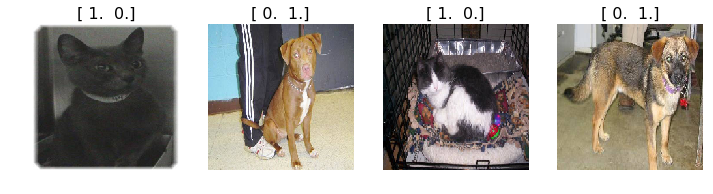

In [78]:
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)
imgs,labels = next(batches)

plots(imgs, titles=labels)

In [84]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds,axis=1)
    
    print('Shape:{}'.format(preds.shape))
    print('First 5 classes:{}'.format(classes[:5]))
    print('First 5 probabilities:{}\n'.format(preds[0,:5]))
    print('Predictions prob/class: ')
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [83]:
pred_batch(imgs)

Shape:(4, 1000)
First 5 classes:['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']
First 5 probabilities:[  1.6647e-05   6.2930e-05   4.1706e-05   6.0851e-05   2.0241e-05]

Predictions prob/class: 
  0.1808/schipperke
  0.4088/vizsla
  0.2874/skunk
  0.6145/malinois
[[  1.6647e-05   6.2930e-05   4.1706e-05 ...,   2.9759e-07   8.2315e-05   2.6111e-04]
 [  5.5924e-08   3.6597e-07   7.6335e-09 ...,   3.2852e-08   2.6688e-07   7.4155e-06]
 [  1.0274e-07   2.5329e-07   1.5955e-06 ...,   4.1911e-08   1.6446e-05   7.2253e-04]
 [  4.3369e-08   3.9696e-08   2.6033e-08 ...,   8.0218e-08   5.4593e-06   5.6319e-06]]
